In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
})

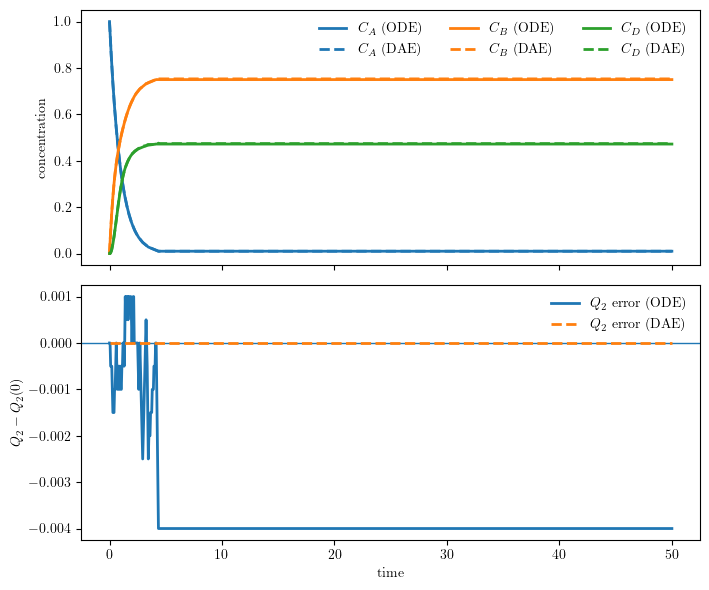

In [12]:
k1, k2, k3 = 1.0, 0.6, 2
dt, T = 0.05, 50.0
t = np.arange(0.0, T + dt, dt)

CA0, CB0, CD0 = 1.0, 0.0, 0.0
Q2 = CA0 + CB0 + 0.5 * CD0

# quantize after each step to make mass drift visible in the ODE plot
ROUND_DECIMALS = 3

def quantize(x):
    return np.round(x, ROUND_DECIMALS) if ROUND_DECIMALS is not None else x

def rhs_ode(CA, CB, CD):
    dCA = -k1 * CA
    dCB =  k1 * CA - k2 * CB + k3 * CD**2
    dCD =  2.0 * k2 * CB - 2.0 * k3 * CD**2
    return dCA, dCB, dCD

Y_ode = np.zeros((t.size, 3))
Y_ode[0] = [CA0, CB0, CD0]
for n in range(t.size - 1):
    CA, CB, CD = Y_ode[n]
    dCA, dCB, dCD = rhs_ode(CA, CB, CD)
    Y_ode[n + 1] = quantize(Y_ode[n] + dt * np.array([dCA, dCB, dCD]))

Y_dae = np.zeros((t.size, 3))
CA, CB = CA0, CB0
CD = 2.0 * (Q2 - CA - CB)
Y_dae[0] = [CA, CB, CD]
for n in range(t.size - 1):
    CD = 2.0 * (Q2 - CA - CB)  # enforce constraint (projection)
    dCA = -k1 * CA
    dCB =  k1 * CA - k2 * CB + k3 * CD**2
    CA, CB = quantize(np.array([CA + dt * dCA, CB + dt * dCB]))
    CD = 2.0 * (Q2 - CA - CB)  # enforce again for stored output
    Y_dae[n + 1] = [CA, CB, CD]

Q_ode = Y_ode[:, 0] + Y_ode[:, 1] + 0.5 * Y_ode[:, 2]
Q_dae = Y_dae[:, 0] + Y_dae[:, 1] + 0.5 * Y_dae[:, 2]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.2, 6.0), sharex=True)

species = ["$C_A$", "$C_B$", "$C_D$"]
for i, s in enumerate(species):
    (ln,) = ax1.plot(t, Y_ode[:, i], lw=2, label=f"{s} (ODE)")
    ax1.plot(t, Y_dae[:, i], "--", lw=2, color=ln.get_color(), label=f"{s} (DAE)")

ax1.set_ylabel("concentration")
ax1.legend(ncols=3, frameon=False)
# ax1.set_title("ODE vs DAE (DAE enforces $Q_2 = C_A + C_B + \\tfrac12 C_D$ exactly)")

ax2.axhline(0.0, lw=1)
ax2.plot(t, Q_ode - Q2, lw=2, label="$Q_2$ error (ODE)")
ax2.plot(t, Q_dae - Q2, "--", lw=2, label="$Q_2$ error (DAE)")
ax2.set_xlabel("time")
ax2.set_ylabel("$Q_2 - Q_2(0)$")
ax2.legend(frameon=False)

fig.tight_layout()
fig.savefig("../../../figs/dae/dae_reaction.pdf", bbox_inches="tight", transparent=True)
plt.show()